In [14]:
import numpy as np
from einops import repeat
import matplotlib.pyplot as plt
import einops
import torch
import torch.nn as nn
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Generate data
def generate_data(N=10000):
    x = np.random.uniform(-1.0, 1.0, N)
    epsilon = (0.5 + 2 * np.abs(x)) * np.random.randn(N)
    y_true = 0.8 * x ** 2 - 0.5 * x + np.sin(5 * x) + 0.5 * np.log(np.abs(x)) # ground truth 함수 값
    y_real = y_true + epsilon # dataset
    return x, y_true, y_real

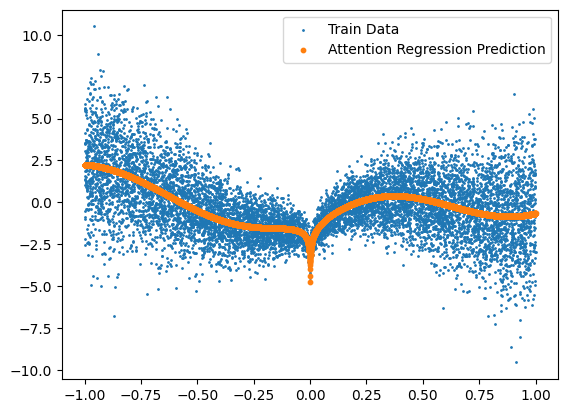

In [5]:
x, y_true, y_real = generate_data()

# Plotting function
def plot_figure(x, y, X, Y, label):
    fig, ax = plt.subplots()
    plt.scatter(X, Y, s=1, label='Train Data')
    plt.scatter(x, y, s=10, label=label)
    ax.legend()
    plt.show()

# Visualize the result
plot_figure(x, y_true, x, y_real, label='Attention Regression Prediction')

# torch attention

In [17]:
class AttentionTorch():
    def __init__(self, key, value, len=0.01):
        self.key = key.reshape(-1, 1) # (m, 1) array
        self.value = value.reshape(-1, 1) # (m, 1) array
        self.len = len

    def compute_attention_score(self, query, key):
        """
        Input:
        - key: (m, d) array
        - query: (b, d) array
        Output:
        - attention score: (b, m) array
        """
        query = einops.repeat(query, 'b d -> b m d', m=1) # query (b, 1) -> (b, 1, 1)
        key = einops.repeat(key, 'm d -> b m d', b=1) # key (m, 1) -> (1, m, 1)
        distance = einops.reduce((query - key)**2 / self.len, 'b m d -> b m', 'sum')
        attention_score = - 0.5 * distance
        return attention_score # attention score (b, m)

    def compute_softmax(self, vector):
        """
        Input:
        - vector: (b, m) array
        Output:
        - softmax vector: (b, m) array
        """
        exp_v = torch.exp(vector)
        attention_weight = exp_v / torch.sum(exp_v, axis=1, keepdims=True)
        return attention_weight

    def compute_attention_weight(self, query, key):
        """
        Input:
        - key: (m, d) array
        - query: (b, d) array
        Output:
        - attention weight: (b, m) array
        """
        score_vector = self.compute_attention_score(query, key) # (b, m)
        attention_weight = self.compute_softmax(score_vector) # (b, m)

        return attention_weight

    def compute_attention(self, query, key, value):
        """
        Input:
        - query: (b, d) array
        - key: (m, d) array
        - value: (m, d) array
        Output:
        - attention output: (b, d) array
        """
        attention_weight = self.compute_attention_weight(query, key) # (b, m)
        attention_output = attention_weight @ value # (b, m) @ (m, 1) -> (b, 1)
        return attention_output # (b, 1)

    def __call__(self, query):
        return self.compute_attention(query, self.key, self.value) # Outputs (b, 1) >> (100, 1)

In [22]:
x_query = np.linspace(-1, 1, 100) # test data >> 100개의 query
x_key = x.reshape(-1, 1) # train data (x_real) >> 10000개의 key
y_value = y_real.reshape(-1, 1) # y_real >> 10000개의 value(key개 개수와 동일한 개수의 value가 있어야 함)
print(f'query, key, value >> {x_query.shape}/{x_key.shape}/{y_value.shape}')

X_test_tensor = torch.tensor(x_query, dtype=torch.float32, requires_grad=False).reshape(-1, 1).to(device) # query
X_tensor = torch.tensor(x_key, dtype=torch.float32, requires_grad=False).reshape(-1, 1).to(device) # key
Y_tensor = torch.tensor(y_value, dtype=torch.float32, requires_grad=False).reshape(-1, 1).to(device) # value

print(f'tensor query, key, value >> {X_test_tensor.shape}/{X_tensor.shape}/{Y_tensor.shape}')

query, key, value >> (100,)/(10000, 1)/(10000, 1)
tensor query, key, value >> torch.Size([100, 1])/torch.Size([10000, 1])/torch.Size([10000, 1])


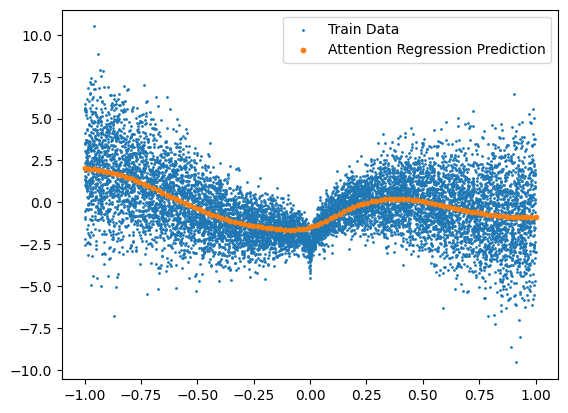

Test error: 0.030330414501115333


In [49]:
def target_func(x):
    return 0.8 * x ** 2 - 0.5 * x + np.sin(5 * x) + 0.5 * np.log(np.abs(x))

attention_model = AttentionTorch(key=X_tensor, value=Y_tensor) # b=100, m=10000
Y_pred= attention_model(X_test_tensor)

# Flatten the predictions for plotting
Y_pred = Y_pred.flatten()

Y_real = target_func(x_query) # x_query (1, 100)에 대한 ground truth 함수값

# Visualize the result
plot_figure(X_test_tensor, Y_pred, x, y_real, label='Attention Regression Prediction')
print(f"Test error: {np.mean((Y_real - Y_pred.detach().cpu().numpy())**2)}")

# trainable attention

In [40]:
class AttentionModule(nn.Module): 
    def __init__(self, d_output=1, d=100): 
        super().__init__() 
        self.d = d 
        self.d_output = d_output 
        ### projection matrices
        self.K = nn.LazyLinear(self.d) # key (m, d_k) > (m, d)
        self.Q = nn.LazyLinear(self.d) # query (b, d_q) > (b, d)
        self.V = nn.LazyLinear(self.d_output) # value (m, d_k) > (m, d_output)

    def compute_attention_score(self, query, key):
        """
        Input:
        - key: (m, d) array
        - query: (b, d) array
        Output:
        - attention score: (b, m) array
        """
        query = einops.repeat(query, 'b d -> b m d', m=1) # query (b, d) -> (b, 1, d)
        key = einops.repeat(key, 'm d -> b m d', b=1) # key (m, d) -> (1, m, d)
        distance = einops.reduce((query - key)**2 / self.d, 'b m d -> b m', 'sum') # (b, m)
        attention_score = - 0.5 * distance
        return attention_score

    def compute_softmax(self, vector):
        """
        Input:
        - vector: (b, m) array
        Output:
        - softmax vector: (b, m) array
        """
        exp_v = torch.exp(vector)
        attention_weight = exp_v / torch.sum(exp_v, axis=1, keepdims=True)
        return attention_weight

    def compute_attention_weight(self, query, key):
        """
        Input:
        - key: (m, d) array
        - query: (b, d) array
        Output:
        - attention weight: (b, m) array
        """
        score_vector = self.compute_attention_score(query, key) # (b, m)
        attention_weight = self.compute_softmax(score_vector) # (b, m)

        return attention_weight

    def compute_attention(self, query, key, value):
        """
        Input:
        - query: (b, d) array
        - key: (m, d) array
        - value: (m, d) array
        Output:
        - attention output: (b, d) array
        """
        attention_weight = self.compute_attention_weight(query, key)
        attention_output = attention_weight @ value # (b, m) @ (m, d_output) -> (b, d_output)
        return attention_output # (b, d_output)

    def forward(self, query, key, value): 
        query = self.Q(query) # (b, d)
        key = self.K(key) # (m, d)
        value = self.V(value) # (m, d_output)
        return self.compute_attention(query, key, value) # (b, d_output)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


AttentionModule(
  (K): LazyLinear(in_features=0, out_features=10, bias=True)
  (Q): LazyLinear(in_features=0, out_features=10, bias=True)
  (V): LazyLinear(in_features=0, out_features=1, bias=True)
)
Test error: 1.2823785543441772


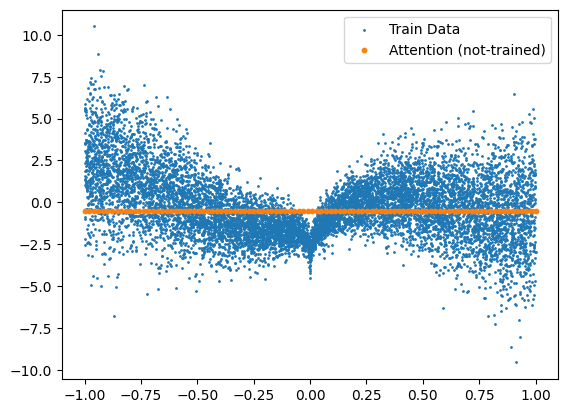

In [43]:
model = AttentionModule(d_output=1, d=10).to(device)
print(model)

test_pred = model(query=X_test_tensor, key=X_tensor, value=Y_tensor)
print(f"Test error: {np.mean((Y_real - test_pred.detach().cpu().numpy())**2)}")
plot_figure(X_test_tensor, test_pred.detach().cpu().numpy(), X_tensor, Y_tensor, 'Attention (not-trained)')

In [94]:
model = AttentionModule(d_output=1, d=5).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fun = nn.MSELoss()

#중첩함수 -> 코드 수정을 덜 할 수 있음
def make_train_step(model, optimizer, loss_func):
    def train_step(query, key, value, target):
        model.train()
        predict = model(query, key, value) # forward pass
        loss = loss_func(predict, target) # loss computation
        loss.backward() # backward pass
        optimizer.step() # gradient descent
        optimizer.zero_grad() # reset gradient
        return loss.item()
    return train_step

train_step = make_train_step(model, optimizer, loss_fun)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [102]:
def train(batch_size=256, epoch=300):
    index_set = np.arange(X_tensor.shape[0])
    num_batch = X_tensor.shape[0] // batch_size
    equal_batches = num_batch * batch_size # 배치 개수 batch_size개로 같은 index 개수

    for _ in range(epoch):
        '''
        # YOUR CODE: minibatch sampling 을 위한 idx_list 리스트를 구현하세요
        # - 조건 1. batch 크기는 256,
        # - 조건 2. 매 epoch 마다 idx_list 가 랜덤하게 바뀌어야 합니다
        '''
        index_set = np.random.permutation(index_set) # 각 epoch마다 index를 섞어줌 << shuffle 이용시 원본도 바뀐다.
        idx_list = np.array_split(index_set[:equal_batches], num_batch) # equal_batches까지 batch_size로 나누어서 mini-batch 만든다.
        if index_set[equal_batches:] is not None: # 나누어 떨어지지 않는 경우 << equal_batches에 포함되지 않는 남은 index를 idx_list에 추가
            idx_list.append(index_set[equal_batches:])
        
        # training
        loss = 0
        for index in idx_list:
            query = X_tensor[index]
            target = Y_tensor[index] # ground truth
            key = X_tensor
            value = Y_tensor
            loss += batch_size * train_step(query, key, value, target)
        loss /= X_tensor.shape[0]

        if _ % 10 == 0:
            model.eval()
            test_pred = model(query=X_test_tensor, key=X_tensor, value=Y_tensor).detach().cpu().numpy()
            test_loss = np.mean((Y_real - test_pred)**2)
            print(f'epoch: {_}, Train loss: {loss}, Test loss:{test_loss}')

In [103]:
train(batch_size=512, epoch=300)

epoch: 0, Train loss: 4.11825849609375, Test loss:1.396638886377932
epoch: 10, Train loss: 3.97083037109375, Test loss:1.2687004758466627
epoch: 20, Train loss: 3.895698327636719, Test loss:1.2145026272209691
epoch: 30, Train loss: 3.7996896484375, Test loss:1.1966597755759663
epoch: 40, Train loss: 3.7332956420898435, Test loss:1.2256496424717105
epoch: 50, Train loss: 3.708177893066406, Test loss:1.276835479112795
epoch: 60, Train loss: 3.6827989379882813, Test loss:1.3188075662591612
epoch: 70, Train loss: 3.6676940795898436, Test loss:1.3453296827357084
epoch: 80, Train loss: 3.6108552124023436, Test loss:1.3649547857679771
epoch: 90, Train loss: 3.6042210693359373, Test loss:1.3816818472883765
epoch: 100, Train loss: 3.5855321044921875, Test loss:1.4005792892840925
epoch: 110, Train loss: 3.5526516235351564, Test loss:1.4215083392806143
epoch: 120, Train loss: 3.5296274780273436, Test loss:1.443729567493149
epoch: 130, Train loss: 3.4844853881835935, Test loss:1.4710178385338717
e

KeyboardInterrupt: 